# Model Selection - RENTALS

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.svm import SVR
from scipy.stats import randint, uniform,loguniform
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch import nn
import os
os.chdir("../..")
from sibr_module import BigQuery, Logger, CStorage

from src.sibr_market_training import ParamTuning

/Users/sigvardbratlie/Documents/Projects/sibr_market_training/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dataset = 'rentals'
logger = Logger(f'model_selection{dataset.capitalize()}')
bq = BigQuery(logger=logger,dataset=dataset)
cs = CStorage(logger=logger, bucket_name='sibr-market-bucket')
logger.debug(f'Dataset: {dataset}')

2025-08-03 13:13:14,938 - model_selectionRentals - INFO - Cloud Logging is disabled. Using local logging to /Users/sigvardbratlie/Documents/Projects/sibr_market_training/logfiles/model_selectionRentals.log
2025-08-03 13:13:14,942 - model_selectionRentals - INFO - BigQuery client initialized with project_id: sibr-market
2025-08-03 13:13:14,943 - model_selectionRentals - INFO - Google Cloud Storage client initialized with bucket: sibr-market-bucket
2025-08-03 13:13:14,944 - model_selectionRentals - DEBUG - Dataset: rentals


In [3]:
data = bq.read_rentals(task = "train", random_samples=0.3, limit = 4000)
df_a = data.get("rentals")
df_o = data.get("rentals_oslo")
df_co = data.get("rentals_co-living")

2025-08-03 13:13:21,654 - model_selectionRentals - INFO - 4000 rows read from rentals. Query: 
        SELECT
        a.*,
        CASE
            WHEN COALESCE(p.n, 0) < 3 THEN m.rent_pr_sqm
 ... (truncated)
2025-08-03 13:13:24,773 - model_selectionRentals - INFO - 2924 rows read from rentals. Query: 
        WITH OsloRentals AS (
        SELECT
            h.*,
            go.BYDELSNAVN AS district... (truncated)
2025-08-03 13:13:28,629 - model_selectionRentals - INFO - 4000 rows read from rentals. Query: 
        WITH OsloRentals AS (
        SELECT
            h.*,
            go.BYDELSNAVN AS district... (truncated)
2025-08-03 13:13:28,665 - model_selectionRentals - INFO - Length's of dataframes: 	 rentals 4000, rental_oslo 4000, rental_co-living 2924


## Hyper parameter tuning

In [4]:
params_rf = {
    'model__n_estimators': randint(100, 1500),  # Litt redusert øvre grense for raskere søk
    'model__max_depth': randint(5, 50),        # Redusert øvre grense
    'model__min_samples_leaf': randint(1, 10),
    'model__bootstrap': [True, False],
    'model__random_state': randint(0, 100)     # Inkludert som i din originale kode
}
params_xgb = {
    'model__n_estimators': randint(100, 1500),
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__max_depth': randint(3, 15),           # Litt justert range
    'model__subsample': uniform(0.6, 0.4),        # Genererer fra 0.6 til 1.0
    'model__random_state': randint(0, 100)
}
params_cat = {
    'model__iterations': randint(100, 1500),      # Samme som n_estimators
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__depth': randint(3, 10),               # Samme som max_depth
    'model__l2_leaf_reg': loguniform(1, 10),      # Viktig regulariseringsparameter for CatBoost
    'model__random_state': randint(0, 100)                     # Fast verdi, teller ikke mot justerbare
}
params_lgbm = {
    # Velger 4-5 kjerne-ytelsesparametere
    'model__n_estimators': randint(100, 1500),
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__num_leaves': randint(20, 150),  # <--- Den viktigste parameteren for LightGBM!
    'model__reg_alpha': loguniform(1e-8, 1.0), # L1 regularisering
    'model__reg_lambda': loguniform(1e-8, 1.0), # L2 regularisering
    'model__random_state': randint(0, 100)
}

params_svr = {
    'model__kernel': [
                    #'linear', 
                      'rbf', 
                      #'poly'
                      ],
    'model__C': loguniform(1, 200),
    'model__gamma': loguniform(0.001, 1),
    'model__epsilon': uniform(0.01, 0.5),
}

models = {
    #'RandomForest': (RandomForestRegressor(), params_rf),
    #"SVR" : (SVR(), params_svr),
    #'XGBoost': (XGBRegressor(), params_xgb),
    'CatBoost': (CatBoostRegressor(silent=True), params_cat),
    #'LightGBM': (LGBMRegressor(), params_lgbm)
}

In [5]:
model_a = ParamTuning(dataset_name='rentals', dataframe=df_a, target='monthly_rent', model_params=models, logger=logger)
model_a.model_selection(models=models)

2025-08-03 13:15:51,879 - model_selectionRentals - INFO - 
 
 -------- MODEL SELECTION FOR RENTALS --------
2025-08-03 13:15:51,886 - model_selectionRentals - INFO - Train set size: 3200, Test set size: 800
2025-08-03 13:15:51,886 - model_selectionRentals - INFO - Columns in train set: ['bedrooms', 'floor', 'primary_area', 'sqm_pr_bedroom', 'dealer_True', 'eq_power_True', 'eq_internet_True', 'eq_tv_True', 'eq_hot_water_True', 'eq_water_True', 'eq_heating_True', 'eq_parking_True', 'eq_household_appliances_True', 'eq_furniture_True', 'day', 'month', 'year', 'property_type_enebolig', 'property_type_hybel', 'property_type_leilighet', 'property_type_rekkehus', 'property_type_tomannsbolig', 'ref_rent_pr_sqm', 'ref_rent_pr_bedroom', 'lat', 'lng', 'areal_befolkning_ArealKm2', 'areal_befolkning_FolkeLandArealKm2', 'areal_befolkning_Folkemengde', 'areal_befolkning_LandArealKm2', 'inntekt_AvtArbTid', 'inntekt_AvtaltManedslonn', 'inntekt_Bonus', 'inntekt_Manedslonn', 'inntekt_Overtid', 'inntekt_Ur

Fitting 3 folds for each of 50 candidates, totalling 150 fits


2025-08-03 13:17:21,175 - model_selectionRentals - INFO - CatBoost model best parameters: {'model__depth': 7, 'model__iterations': 1223, 'model__l2_leaf_reg': np.float64(1.3895264494261033), 'model__learning_rate': np.float64(0.09150423569345205), 'model__random_state': 52} on rentals
2025-08-03 13:17:21,176 - model_selectionRentals - INFO - Best score for CatBoost: Train: 225883.64456655193, Test: 6930280.967362911, R2 (test): 0.8127240499460963, R2 (train): 0.9942675143011722 on rentals 

2025-08-03 13:17:21,177 - model_selectionRentals - INFO -  
 ===== RESULTS FOR rentals =====
2025-08-03 13:17:21,177 - model_selectionRentals - INFO - Model: CatBoost | r2_test 0.8127240499460963 | r2_train 0.9942675143011722 	 | 	 PARAMETERS {'model__depth': 7, 'model__iterations': 1223, 'model__l2_leaf_reg': np.float64(1.3895264494261033), 'model__learning_rate': np.float64(0.09150423569345205), 'model__random_state': 52}


In [7]:
model_co = ParamTuning(dataset_name='rentals_co-living', dataframe=df_co, target='monthly_rent', model_params=models, logger=logger)
model_co.model_selection(models = models)

2025-08-03 13:18:55,682 - model_selectionRentals - INFO - 
 
 -------- MODEL SELECTION FOR RENTALS_CO-LIVING --------
2025-08-03 13:18:55,688 - model_selectionRentals - INFO - Train set size: 2339, Test set size: 585
2025-08-03 13:18:55,688 - model_selectionRentals - INFO - Columns in train set: ['floor', 'eq_power_True', 'eq_internet_True', 'eq_tv_True', 'eq_hot_water_True', 'eq_water_True', 'eq_heating_True', 'eq_parking_True', 'eq_household_appliances_True', 'eq_furniture_True', 'day', 'month', 'year', 'ref_rent', 'lat', 'lng', 'district_name_Alna', 'district_name_Bjerke', 'district_name_Frogner', 'district_name_Gamle Oslo', 'district_name_Grorud', 'district_name_Grünerløkka', 'district_name_Marka Nord', 'district_name_Marka Øst', 'district_name_Nordre Aker', 'district_name_Nordstrand', 'district_name_Sagene', 'district_name_Sentrum', 'district_name_St. Hanshaugen', 'district_name_Stovner', 'district_name_Søndre Nordstrand', 'district_name_Ullern', 'district_name_Vestre Aker', 'dist

Fitting 3 folds for each of 50 candidates, totalling 150 fits


2025-08-03 13:19:32,645 - model_selectionRentals - INFO - CatBoost model best parameters: {'model__depth': 9, 'model__iterations': 809, 'model__l2_leaf_reg': np.float64(3.241509528627272), 'model__learning_rate': np.float64(0.04135867955263894), 'model__random_state': 36} on rentals_co-living
2025-08-03 13:19:32,645 - model_selectionRentals - INFO - Best score for CatBoost: Train: 589769.5179105289, Test: 2189836.922972599, R2 (test): 0.2671924460962548, R2 (train): 0.8152872939353275 on rentals_co-living 

2025-08-03 13:19:32,646 - model_selectionRentals - INFO -  
 ===== RESULTS FOR rentals_co-living =====
2025-08-03 13:19:32,646 - model_selectionRentals - INFO - Model: CatBoost | r2_test 0.2671924460962548 | r2_train 0.8152872939353275 	 | 	 PARAMETERS {'model__depth': 9, 'model__iterations': 809, 'model__l2_leaf_reg': np.float64(3.241509528627272), 'model__learning_rate': np.float64(0.04135867955263894), 'model__random_state': 36}


In [8]:
model_o = ParamTuning(dataset_name='rentals_oslo', dataframe=df_o, target='monthly_rent', model_params=models, logger=logger)
model_o.model_selection(models = models)

2025-08-03 13:20:34,880 - model_selectionRentals - INFO - 
 
 -------- MODEL SELECTION FOR RENTALS_OSLO --------
2025-08-03 13:20:34,885 - model_selectionRentals - INFO - Train set size: 3200, Test set size: 800
2025-08-03 13:20:34,886 - model_selectionRentals - INFO - Columns in train set: ['bedrooms', 'floor', 'primary_area', 'sqm_pr_bedroom', 'dealer_True', 'eq_power_True', 'eq_internet_True', 'eq_tv_True', 'eq_hot_water_True', 'eq_water_True', 'eq_heating_True', 'eq_parking_True', 'eq_household_appliances_True', 'eq_furniture_True', 'day', 'month', 'year', 'property_type_enebolig', 'property_type_hybel', 'property_type_leilighet', 'property_type_rekkehus', 'property_type_tomannsbolig', 'ref_rent_pr_sqm', 'ref_rent_pr_bedroom', 'lat', 'lng', 'ref_rent', 'district_name_Alna', 'district_name_Bjerke', 'district_name_Frogner', 'district_name_Gamle Oslo', 'district_name_Grorud', 'district_name_Grünerløkka', 'district_name_Marka Nord', 'district_name_Marka Øst', 'district_name_Nordre Aker

Fitting 3 folds for each of 50 candidates, totalling 150 fits


2025-08-03 13:21:26,206 - model_selectionRentals - INFO - CatBoost model best parameters: {'model__depth': 8, 'model__iterations': 1375, 'model__l2_leaf_reg': np.float64(1.1097554561103098), 'model__learning_rate': np.float64(0.03023795012558475), 'model__random_state': 79} on rentals_oslo
2025-08-03 13:21:26,207 - model_selectionRentals - INFO - Best score for CatBoost: Train: 961866.3415724174, Test: 6622921.350710592, R2 (test): 0.8596329277823035, R2 (train): 0.9788765111597254 on rentals_oslo 

2025-08-03 13:21:26,207 - model_selectionRentals - INFO -  
 ===== RESULTS FOR rentals_oslo =====
2025-08-03 13:21:26,208 - model_selectionRentals - INFO - Model: CatBoost | r2_test 0.8596329277823035 | r2_train 0.9788765111597254 	 | 	 PARAMETERS {'model__depth': 8, 'model__iterations': 1375, 'model__l2_leaf_reg': np.float64(1.1097554561103098), 'model__learning_rate': np.float64(0.03023795012558475), 'model__random_state': 79}


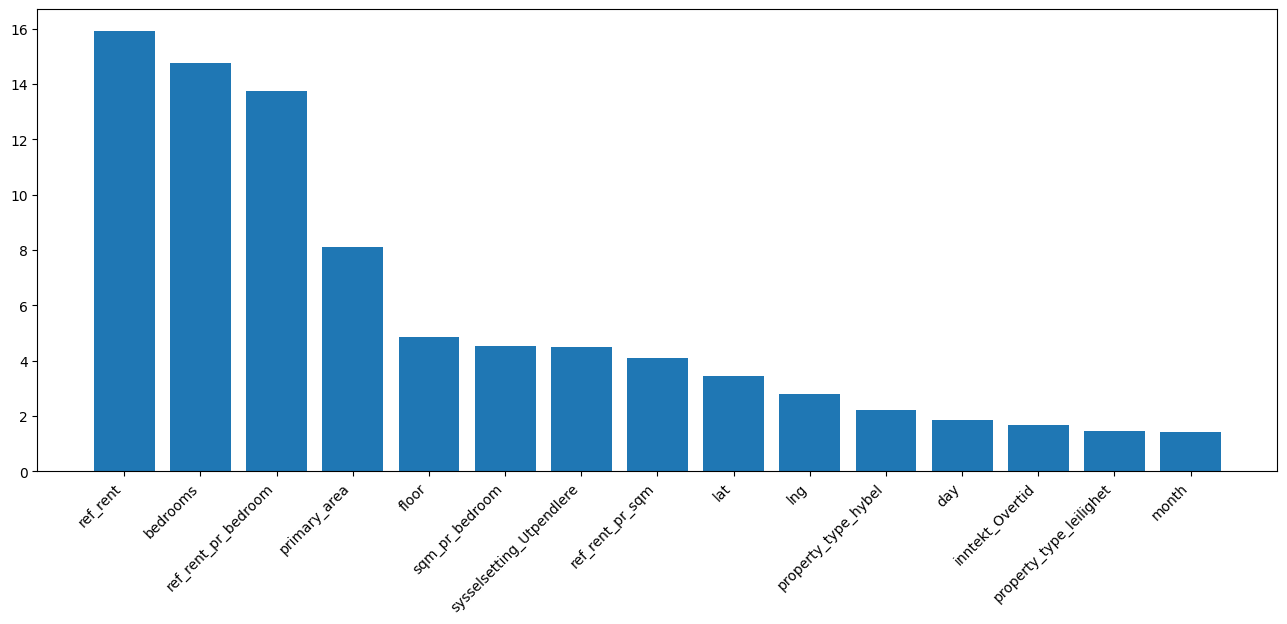

In [10]:
model_a.plot_feat_imp(0)

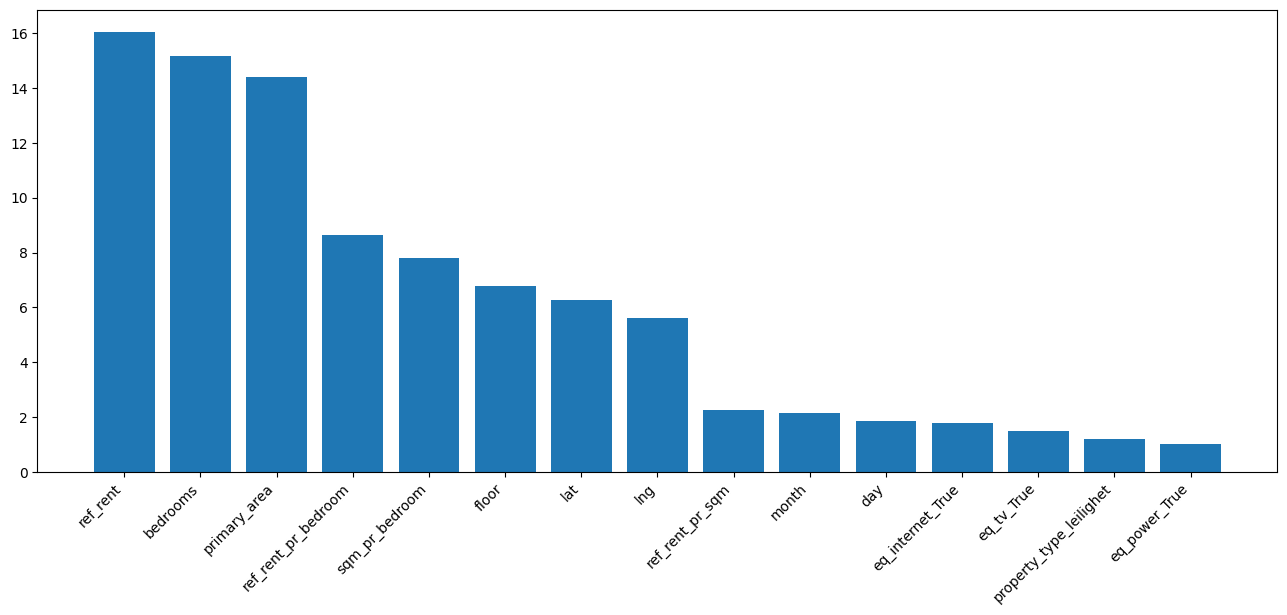

In [11]:
model_o.plot_feat_imp(0)

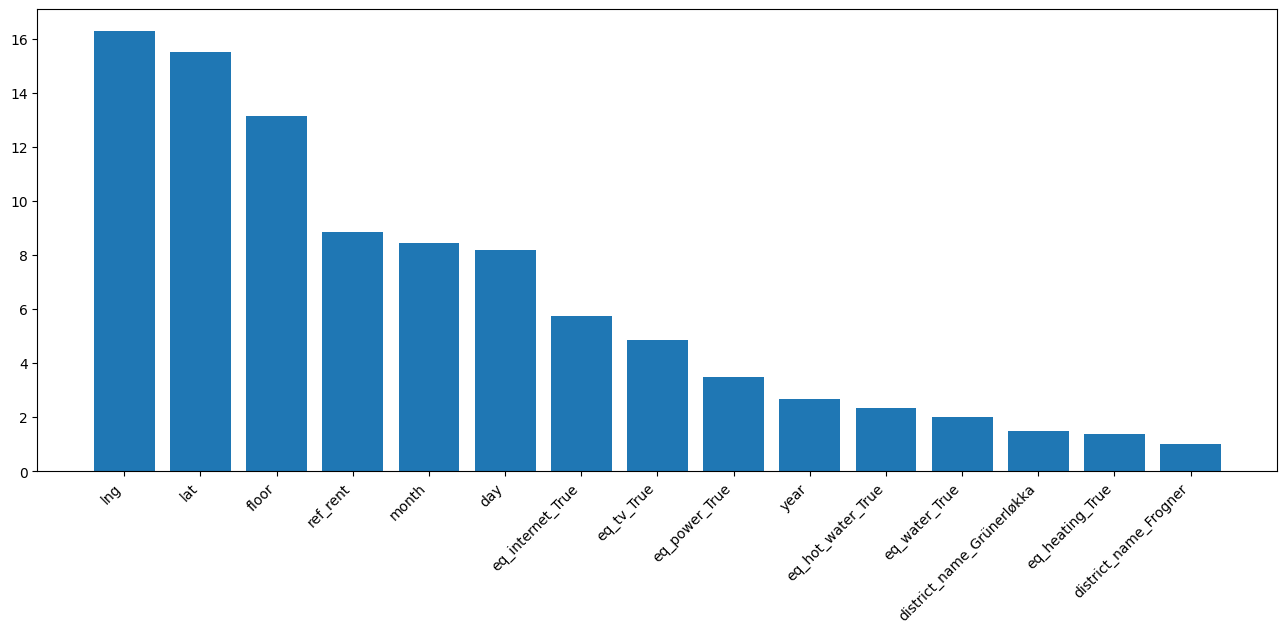

In [13]:
model_co.plot_feat_imp(0)

In [ ]:
feat_imp_o,un_imp_o = get_feat_imp(o.all_results,0)
plot_feat_imp(feat_imp_o)

item_id
364086156    10.126671
329443555     9.510519
364356089     9.071193
366898665     9.433564
389211069     9.711176
               ...    
360912543     8.987322
367298968     9.878221
360581534    10.021315
305401763      9.21044
356775651    10.038936
Name: monthly_rent, Length: 5000, dtype: Float64

In [ ]:
df_a = bq.read_preprocessed(table = 'rentals')

0:	learn: 0.3900446	total: 4.43ms	remaining: 5.09s
1:	learn: 0.3823123	total: 7.74ms	remaining: 4.45s
2:	learn: 0.3747806	total: 10.5ms	remaining: 4.03s
3:	learn: 0.3675517	total: 13.4ms	remaining: 3.85s
4:	learn: 0.3607269	total: 16.9ms	remaining: 3.87s
5:	learn: 0.3546905	total: 20.1ms	remaining: 3.83s
6:	learn: 0.3488402	total: 23ms	remaining: 3.76s
7:	learn: 0.3435698	total: 26.1ms	remaining: 3.73s
8:	learn: 0.3378776	total: 29.2ms	remaining: 3.7s
9:	learn: 0.3323954	total: 32.1ms	remaining: 3.66s
10:	learn: 0.3273360	total: 35.2ms	remaining: 3.64s
11:	learn: 0.3223994	total: 38ms	remaining: 3.6s
12:	learn: 0.3182715	total: 40.8ms	remaining: 3.57s
13:	learn: 0.3139610	total: 44.1ms	remaining: 3.58s
14:	learn: 0.3098195	total: 47.4ms	remaining: 3.59s
15:	learn: 0.3058397	total: 50.5ms	remaining: 3.58s
16:	learn: 0.3025032	total: 53.8ms	remaining: 3.59s
17:	learn: 0.2989117	total: 56.7ms	remaining: 3.57s
18:	learn: 0.2955919	total: 59.8ms	remaining: 3.56s
19:	learn: 0.2925433	total: 

In [80]:
print(f'MSE test: {mse_test}, MSE train: {mse_train}, R2 test: {r2_test}, R2 train: {r2_train}')

MSE test: 7118746.414743473, MSE train: 6489132.78249296, R2 test: 0.7994862208108579, R2 train: 0.8168895595152792


In [ ]:
params = {'model__depth': 6, 'model__iterations': 1151, 'model__l2_leaf_reg': np.float64(1.6536379754545745), 'model__learning_rate': np.float64(0.04123212300418546), 'model__random_state': 61}

params = {k.replace('model__', ''): v for k, v in params.items()}
pipe = Pipeline([
            ('impute', SimpleImputer()),
            ('scaler', StandardScaler()),
            #('Kernel_PCA', PCA(n_components=0.95)),  # Optional: PCA for dimensionality reduction
            ('model', CatBoostRegressor(**params)),
        ])

pipe.fit(X_train,y_train)

y_preds_train = pipe.predict(X_train)
y_preds = pipe.predict(X_test)
mse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_preds))
mse_train = mean_squared_error(np.expm1(y_train), np.expm1(y_preds_train))
r2_test = r2_score(np.expm1(y_test), np.expm1(y_preds))
r2_train = r2_score(np.expm1(y_train), np.expm1(y_preds_train))
residuals = np.expm1(y_test) - np.expm1(y_preds)
print(f'MSE test: {mse_test}, MSE train: {mse_train}, R2 test: {r2_test}, R2 train: {r2_train}')

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 141890122 to 378770758
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   monthly_rent                  5000 non-null   Int64  
 1   bedrooms                      5000 non-null   Int64  
 2   floor                         5000 non-null   Int64  
 3   primary_area                  5000 non-null   Int64  
 4   sqm_pr_bedroom                4724 non-null   float64
 5   eq_power_True                 5000 non-null   boolean
 6   eq_internet_True              5000 non-null   boolean
 7   eq_tv_True                    5000 non-null   boolean
 8   eq_hot_water_True             5000 non-null   boolean
 9   eq_water_True                 5000 non-null   boolean
 10  eq_heating_True               5000 non-null   boolean
 11  eq_parking_True               5000 non-null   boolean
 12  eq_household_appliances_True  5000 non-null   boolean
